In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

In [2]:
from src.constants import vocab
from src.dataset import LipDataset
from src.utils import char_to_num, num_to_char, get_word2idx_idx2word

In [2]:
# from src import download_data

# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# download_data.download_data(url)

In [5]:
# vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [10]:
# word2idx = {word: idx for idx, word in enumerate(vocab)}

# # word2idx['<PAD>'] = len(word2idx)
# # word2idx['<START>'] = len(word2idx)
# # word2idx['<END>'] = len(word2idx)
# # word2idx['<UNK>'] = len(word2idx)

# idx2word = {idx: word for word, idx in word2idx.items()}
# vocab_size = len(word2idx)


In [101]:
# class LipDataset(Dataset):
#     def __init__(self, data_dir: str, label_dir: str, vocab: list, word2idx: dict, idx2word: dict, transform=None):
#         self.data_dir = data_dir
#         self.label_dir = label_dir
#         self.transform = transform
#         self.data = os.listdir(data_dir)
#         self.label = os.listdir(label_dir)
#         self.vocab = vocab
#         self.word2idx = word2idx
#         self.idx2word = idx2word

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         data_path = os.path.join(self.data_dir, self.data[idx])
#         label_path = os.path.join(self.label_dir, self.label[idx])

#         assert os.path.exists(data_path), f"Data path {data_path} does not exist"
#         assert os.path.exists(label_path), f"Label path {label_path} does not exist"

#         assert (
#             data_path.split("/")[-1].split(".")[0]
#             == label_path.split("/")[-1].split(".")[0]
#         ), "Data and label file names do not match"

#         frames = self.load_video(data_path)

#         label = self.load_alignment(label_path)

#         return frames, label

#     def load_video(self, path: str) -> torch.Tensor:
#         cap = cv2.VideoCapture(path)
#         num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

#         frames = []
#         for i in range(num_frames):
#             ret, frame = cap.read()
            
#             # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
#             frame = frame[
#                 190:236, 80:220
#             ]  # TODO: Make it dynamic using dlib  # Take only the lip part of the frame
            
#             if self.transform:
#                 frame = self.transform(frame)

#             frames.append(frame)

#         cap.release()
        
#         frames = torch.stack(frames)
        
#         std = torch.std(frames)
#         mean = torch.mean(frames)
        
#         frames = (frames - mean) / std # Normalize the frames (z-score normalization

#         return frames # (T, H, W, C)
    
    
#     def load_alignment(self, path: str) -> torch.Tensor:
#         with open(path, "r") as f:
#             lines = f.readlines() 
#         tokens = []
#         for line in lines:
#             line = line.split()
#             if line[2] != "sil":
#                 # tokens = [*tokens, ' ',line[2]]
#                 tokens.append(' ')
#                 tokens.extend(list(line[2]))  

#         token_nums = char_to_num(tokens, self.word2idx)

        
#         return torch.tensor(token_nums[1:], dtype=torch.long)

ImportError: cannot import name 'get_word2idx_idx2word' from 'src.utils' (d:\Vegeta\Projects\DL projects\LipNet\src\utils.py)

In [3]:
word2idx, idx2word = get_word2idx_idx2word(vocab)

data_transform = transforms.Compose(
    [
        transforms.ToPILImage(),                      # Convert the OpenCV image (NumPy array) to a PIL image
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale# Resize the frame to (46, 140) as in your slicing operation
        transforms.ToTensor(),                        # Convert the PIL image to a PyTorch tensor (values between 0 and 1)
        # transforms.Normalize(mean=[0.5], std=[0.5]) 
    ]
)

data_dir = "data/s1"
label_dir = "data/alignments/s1"

dataset = LipDataset(data_dir, label_dir, transform=data_transform, vocab=vocab, word2idx=word2idx, idx2word=idx2word)

In [4]:
frames, label = dataset[0]
print(frames.shape, label.shape)

torch.Size([75, 1, 46, 140]) torch.Size([21])


In [5]:
frames[0]

tensor([[[1.4633, 1.4633, 1.4258,  ..., 0.3741, 0.3741, 0.3741],
         [1.4633, 1.4633, 1.4258,  ..., 0.3741, 0.3741, 0.3741],
         [1.4258, 1.4258, 1.4633,  ..., 0.2990, 0.2990, 0.2990],
         ...,
         [1.0502, 1.0502, 1.0126,  ..., 0.1112, 0.1112, 0.0736],
         [1.0502, 1.0502, 1.0126,  ..., 0.1112, 0.0736, 0.0736],
         [1.0502, 1.0502, 1.0126,  ..., 0.0736, 0.0736, 0.0361]]])

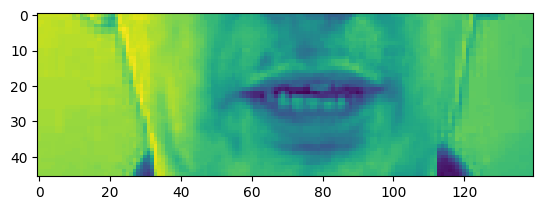

In [6]:
plt.imshow(frames[50].permute(1, 2, 0))

In [7]:
print(num_to_char(label.tolist(), idx2word))

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'f', ' ', 't', 'w', 'o', ' ', 'n', 'o', 'w']
